![logo](https://github.com/donatellacea/DL_tutorials/blob/main/notebooks/figures/1128-191-max.png?raw=true)

# Model-Agnostic Interpretation with Permutation Feature Importance

In this Notebook, we will demonstrate how to use the Permutation Feature Importance method and interpret its results.

--------


## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. To start working on the notebook, click on the following button. This will open this page in the Colab environment, and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/Juelich-2024/xai-for-random-forest/Tutorial_PermutationFeatureImportance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that you opened the notebook in Google Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive, and you can navigate it through the lefthand panel in Colab. You might also have received an email that informs you about the access on your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive
!git clone --branch Juelich-2024 https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git
%cd XAI-Tutorials/xai-for-random-forest

### Imports

Let's start with importing all required Python packages.

In [1]:
import utils
import joblib

import numpy as np

from sklearn.metrics import get_scorer
from sklearn.inspection import permutation_importance

We fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [2]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)

--------

## Data and Model Loading: The California Housing Dataset

In this notebook, we will work with the **California Housing dataset**, containing 20,640 median house values for California districts (expressed in $100,000), which are described by 8 numeric feature. Each row in the dataset represents a block of houses, not a single household. The data pertains to the house prices found in a given California district and some summary statistics about them based on the 1990 census data. Our goal is to **predict price** of house blocks and find the most predictive features.

<center><img src="https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/dataset_california_housing.jpg?raw=true" width="900" /></center>

<font size=1> Source: [Link](https://www.kaggle.com/datasets/harrywang/housing)

In the notebook [*Dataset-Housing.ipynb*](../data_and_models/Dataset-Housing.ipynb), we explain how to do the exploratory data analysis, preprocess the data and in the notebook [*Model-RandomForest.ipynb*](../data_and_models/Model-RandomForest.ipynb) we train a Random Forest model with the given data. The focus of this notebook lies on the interpretation of the trained model and not on the data pre-processing or model training part. Hence, here we simply load the data and the model that we saved in the previous notebook.

In [3]:
# Load and unpack the data
data_and_model = joblib.load(open('../data_and_models/model_randomforest_housing.joblib', 'rb'))
X_train = data_and_model[0]
X_test = data_and_model[1]
y_train = data_and_model[2]
y_test = data_and_model[3]
rf = data_and_model[4]

X_train.head()

/Users/lisa.barros/anaconda3/envs/xai/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.2.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/lisa.barros/anaconda3/envs/xai/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.2.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/lisa.barros/anaconda3/envs/xai/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using v

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,0.147962,1.103425,0.095032,-0.291276,-0.837507,-0.341389,0.023004,-0.044194
1,0.060005,-1.955272,0.010194,-0.628844,1.387765,-0.385798,-0.278685,3.681930
2,0.972407,-1.802337,0.988176,0.035358,0.630775,0.058821,-0.781498,2.642082
3,-1.182429,0.415218,-1.090619,1.610126,-0.635842,-0.688559,0.827506,-0.997388
4,0.464143,1.103425,1.574470,-0.422020,-0.390466,-0.284571,0.224129,-0.650772


Check again how the model performed on the train and test set.

*Note: The $R^2$ is the coefficient of determination, and the closer this value is to 1, the better our model explains the data. A constant model that always predicts the average target value disregarding the input features would get an $R^2$ score of 0. However, the $R^2$ score can also be negative because the model can be arbitrarily worse.*

In [4]:
# is the model performing reasonably on the training data?
print(f'Model Performance on training data: {round(rf.score(X_train, y_train),2)} R^2.')

# is the model performing reasonably on the test data?
print(f'Model Performance on test data: {round(rf.score(X_test, y_test),2)} R^2.')

Model Performance on training data: 0.84 R^2.
Model Performance on test data: 0.72 R^2.


As we can see by the numbers above, our model performs well on the training set and also generalizes well to the independent test set.

*Note: you should keep in mind that interpreting a low-performing model can lead to wrong conclusions.*

## Now, what does my model actually think is important in the data?

### Permutation Feature Importance

We prepared a small [Introduction to Permutation Feature Importance](https://xai-tutorials.readthedocs.io/en/latest/_model_agnostic_xai/pfi.html) for you, to help you understand how this method works.

*Note: we provide all references [here](https://xai-tutorials.readthedocs.io/en/latest/_model_agnostic_xai/pfi.html#references).*

<font color='green'>

#### Question 1: What is achieved by permuting feature values?

<font color='grey'>

#### Your Answer: 
The existing relation between target and the feature are destroyed by randomly assigning new values to the given labels, making it impossible for the model to draw any conclusion from this feature to predict the label.


<font color='green'>

#### Question 2: Would it also be a good idea to permute the target instead of the features?

<font color='grey'>

#### Your Answer: 
No, since we could not measure an effect for each feature anymore.

<font color='green'>

#### Question 3: Why don't we leave out a feature instead of permuting it to measure its importance?

<font color='grey'>

#### Your Answer: 

Leaving out the feature would require training a second model with less input features, which then would make the comparison harder.

Now, let's use Permutation Feature Importance to get insights into the Random Forest Regression model we loaded above. We can use the scikit-learn implementation called `permutation_importance` to get the importance values for the features in our model. For measuring the performance drop when permuting a feature, we use the standard metric of our trained model, which is, in our case, the $R^2$ score. Using the same score enables us to evaluate the performance drop in relation to the baseline performance. We do 20 repetitions of permutation for each feature to get more reliable results.

*Note: this method is a **global** method, which means that it only provides explanations for the full dataset but not for individual examples.*

In [5]:
scorer = get_scorer("r2")

In [6]:
explanation_train = permutation_importance(
    rf,
    X=X_train,
    y=y_train,
    n_repeats=20,
    random_state=seed,
    scoring=scorer
)

explanation_train["feature"] = X_train.columns

We will now plot bar histograms for visualizing the importance of each feature as obtained by the mean over the 20 repetitions. To judge variability, we plot the box plots of the feature importances as well.

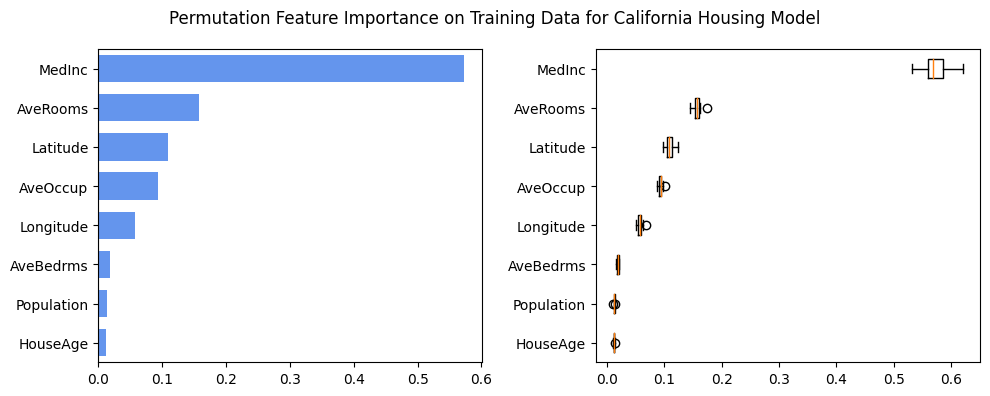

In [7]:
utils.plot_permutation_feature_importance_with_variance(explanation_train, X_train, 'Permutation Feature Importance on Training Data for California Housing Model')

Features with the largest importance score are the ones whose score is most decreased when the feature is permuted, indicating high relevance for the prediction of the target. For our California Housing model, the *median income in a block group* seems to have the highest impact on the model performance. Permuting this feature leads to a $R^2$ score decrease of ~ 0.6. When comparing it to the baseline $R^2$ score of 0.84, we notice that permuting the *median income* feature leads to a model with $R^2$ close to 0, i.e., a constant model that always predicts the average target value disregarding the input features.

We are not restricted to obtaining feature importances of the same data set we used to train the model. Instead, we could use the same approach to identify the most important features in the test set.

<font color='green'>

#### Question 4: How should the feature importance for MedInc be interpreted?

<font color='grey'>

#### Your Answer: 
It is the (average over multiple permutations) decrease of a performance measure - in our case R^2 - compared to a model that did not have the MedInc permuted.

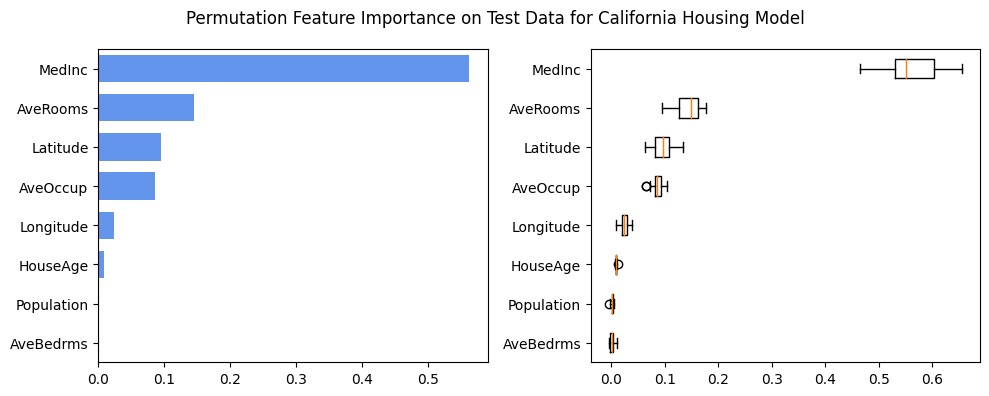

In [8]:
explanation_test = permutation_importance(
    rf,
    X=X_test,
    y=y_test,
    n_repeats=20,
    random_state=seed,
    scoring=scorer)

explanation_test["feature"] = X_test.columns

utils.plot_permutation_feature_importance_with_variance(explanation_test, X_test, 'Permutation Feature Importance on Test Data for California Housing Model')

It seems that for both datasets, largely the same features are identified as important, which is reassuring.

*Note: this agreement of important features between training and testing datasets is not guaranteed. In such cases, it is not straightforward to decide on the "truly important" features for the model.*

<font color='green'>

#### Question 5: What does the negative importance value for Population mean?

<font color='grey'>

#### Your Answer: 
This means that permuting the feature increases the performance of the model. Then it might be advisable to consider removing the feature and to retrain the model.

--------

## Extra Material: Dealing with correlated features

In the introduction material you already learned that applying permutation importance to datasets that contain correlated features can be problematic in various ways.
This is also emphasized in the [scikit_learn documentation](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance):

"*When two features are correlated and one of the features is permuted, the model will still have access to the feature through its correlated feature. This will result in a lower importance value for both features, where they might actually be important.*"

But this is not the only effect that can occur. Below we will see an example where importance is attributed to a feature which is completely unrelated to the target variable because of its correlation to an actually important feature.

Let's create toy data of multiple features of which the first two are highly correlated but only one
of them will be used for computing our target.

In [9]:
# Imports

import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge

In [10]:
# Create toy features
np.random.seed(seed)

corr1 = 0.95
n_vars = 5

means = np.array([i*5 for i in range(n_vars)])
cov = np.diag(np.ones(n_vars))
cov[0, 1] = corr1
cov[1, 0] = corr1

features = np.random.multivariate_normal(means, cov, size=2000)
features = pd.DataFrame(features)
features.columns = ['feature_1','feature_2','feature_3','feature_4','feature_5']

Now lets create a target variable that is computed from all features BUT feature 1, which is highly correlated to feature 2.

In [11]:
# compute target from four features and add noise
np.random.seed(seed)
target_clean = 1.e-1 * np.exp(features.iloc[:, 1]) * 0.3 * np.sin(features.iloc[:, 2]) + 0.5 * np.sin(features.iloc[:, 3]) + 0.1 * np.cos(features.iloc[:, 4])
target = target_clean + .02 * np.random.normal(0, 1, size=len(target_clean))

As we can see in the plot below, feature 1 and feature 2 are highly correlated, while the remaining feature show no correlation amongst each other.  
In addition, from the features that were used to create the target variable, feature 2 and feature 3 correlate with the target variable.

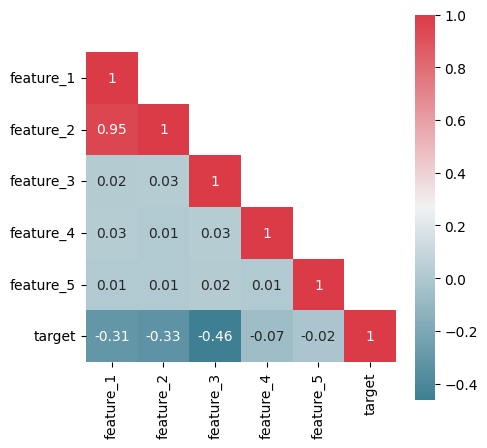

In [12]:
df = features.copy()
df['target'] = target
utils.plot_correlation_matrix(df)

Let's now see how the correlation between feature 1, which was not used to compute the target variable, and feature 2 influences the Permutation Feature Importance! Therefore, we train a model on all features and calculate the feature importance. 

Model Performance on training data: 0.9534265077482174
Model Performance on test data: 0.5588196583491316


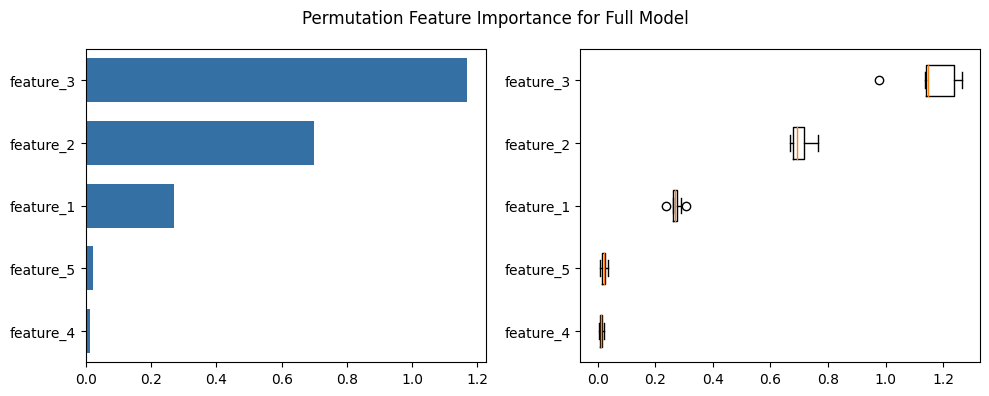

In [13]:
# split data into training and test data, then train model on training data
x_train, x_test, y_train, y_test = train_test_split(features, target, random_state=seed, train_size=0.6)
pipe = Pipeline([
    ("preprocessing", StandardScaler()),
    ("model", KernelRidge(kernel="rbf"))
])
pipe.fit(x_train, y_train)

# model performance on training and test data
print('Model Performance on training data: {}'.format(pipe.score(x_train, y_train)))
print('Model Performance on test data: {}'.format(pipe.score(x_test, y_test)))

# Now back to obtaining importances
explanation_train = permutation_importance(
    pipe,
    X=x_train,
    y=y_train,
    n_repeats=10,
    random_state=seed,
    scoring=scorer)

explanation_train["feature"] = x_train.columns

utils.plot_permutation_feature_importance(explanation_train, x_train, 'Permutation Feature Importance for Full Model')

Next, we remove the highly correlated feature 1, retrain the model and calculate the feature importance. Removing feature 1 should not have a great impact on the model since it was not used to create the target variable.

Model Performance on training data: 0.9562840015862645
Model Performance on test data: 0.6083971437705138


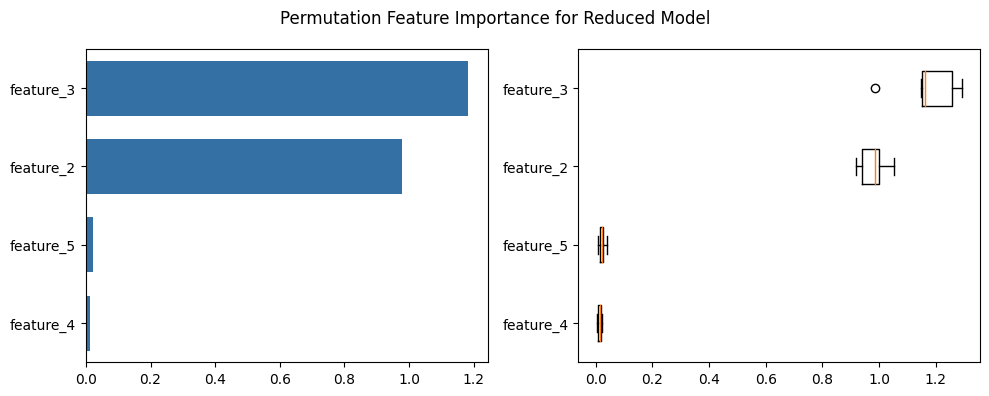

In [14]:
# drop correlated feature 1
features.drop('feature_1', axis=1, inplace=True)

# split data into training and test data, then train model on training data
x_train, x_test, y_train, y_test = train_test_split(features, target, random_state=seed, train_size=0.6)
pipe.fit(x_train, y_train)

# model performance on training and test data
print('Model Performance on training data: {}'.format(pipe.score(x_train, y_train)))
print('Model Performance on test data: {}'.format(pipe.score(x_test, y_test)))

# Now back to obtaining importances
explanation_train = permutation_importance(
    pipe,
    X=x_train,
    y=y_train,
    n_repeats=10,
    random_state=seed,
    scoring=scorer)

explanation_train["feature"] = x_train.columns

utils.plot_permutation_feature_importance(explanation_train, x_train, 'Permutation Feature Importance for Reduced Model')

As can be seen from above, the model performance does not change much when removing feature 1 from the dataset, which indicates that both models are comparable. However, if we look at the feature importance of the full model, we can see that the importance is split between the correlated feature 1 and feature 2. Even though the data we simulated does not depend on feature 1, the model still assigns quite high importance to this feature as well, due to its high correlation with feature 2, which can lead to wrong conclusions during model interpretation! If we compare the feature importance of the full model to the one where we removed feature 1, we can see that the importance of feature 2 increases, although the importance of the remaining features stays the same. This illustrates why you have to be careful when using Permutation Feature Importance for models that were trained on datasets with high feature correlations!